Here, we'll test how dynamically novel the components of the CST- and RTT-unique spaces are.

First, load the data and split the subspaces out:

In [2]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split_test.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series(index=pd.MultiIndex.from_product(


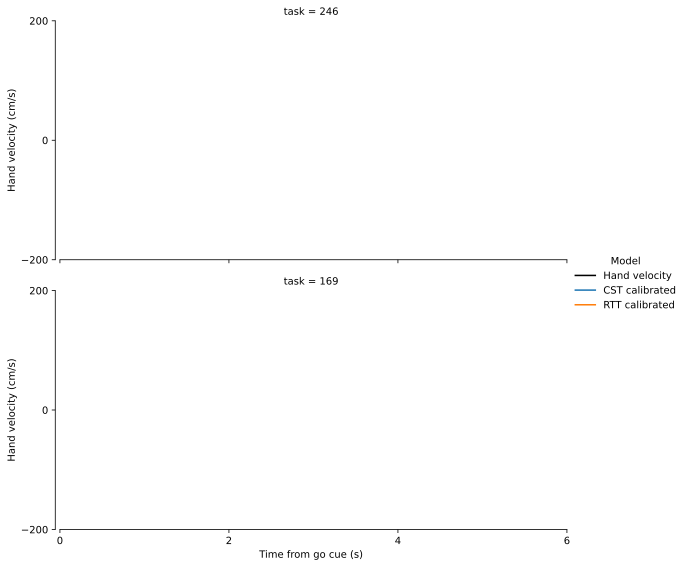

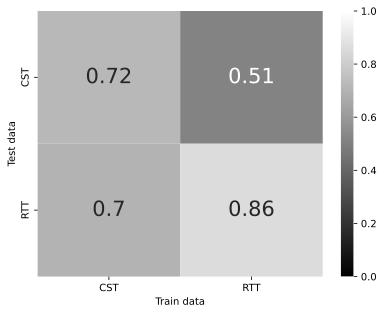

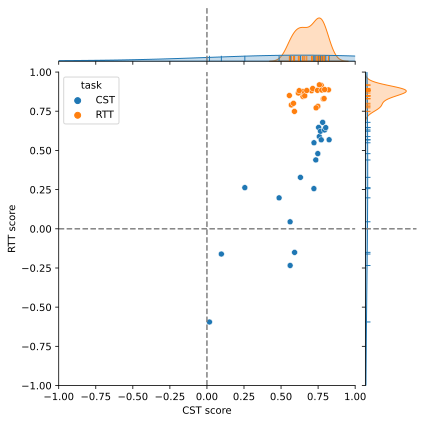

In [3]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca',
    hand_or_cursor='Hand',
    pos_or_vel='velocity',
    trace_component=0
)


Let's double-check that the split worked satisfactorily with a variance plot.

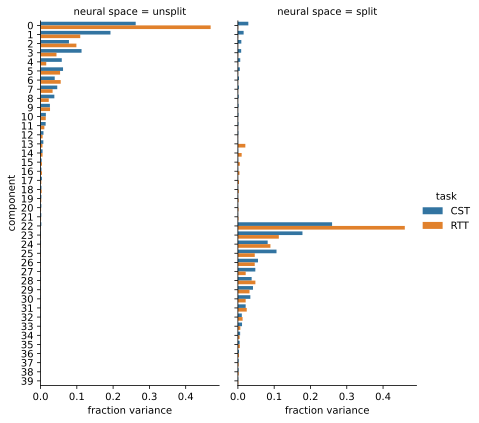

In [4]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

In [62]:
src.plot.plot_single_trial_split_var(td,signal='lfads_rates_joint_pca')

task                       CST
CST space variance    0.100324
RTT space variance    0.008939
Name: 11, dtype: object


/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



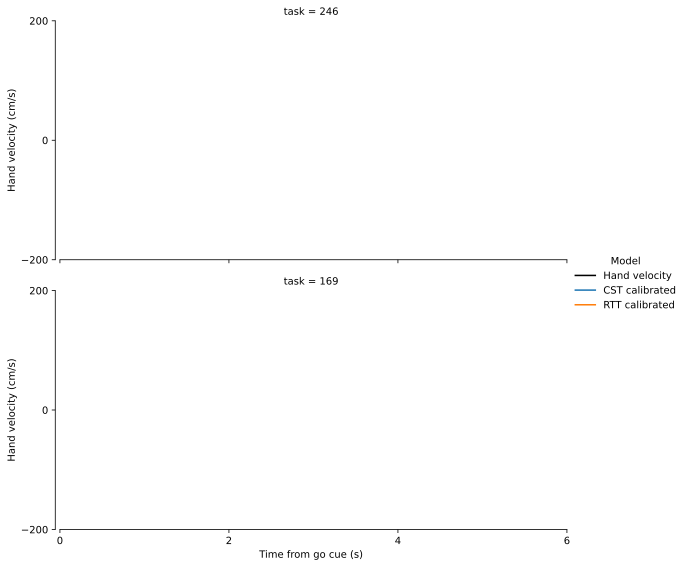

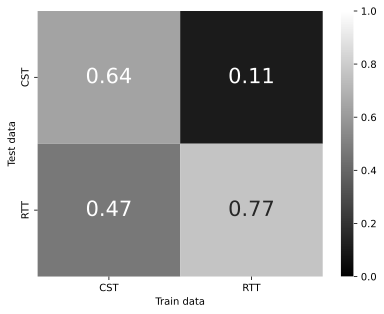

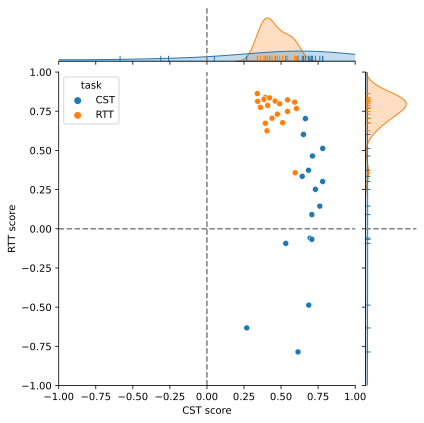

In [6]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_shared',
    hand_or_cursor='Hand',
    pos_or_vel='velocity',
    trace_component=0,
)


/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



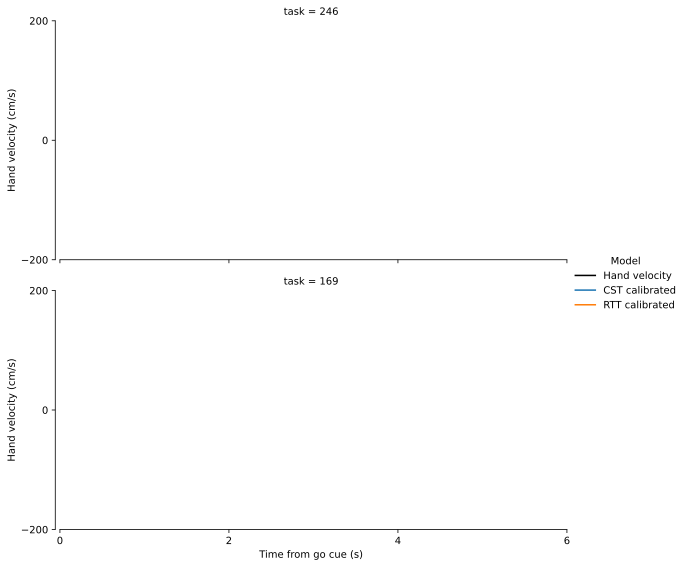

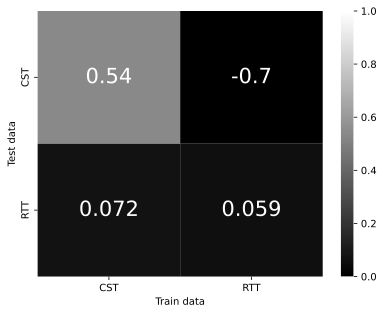

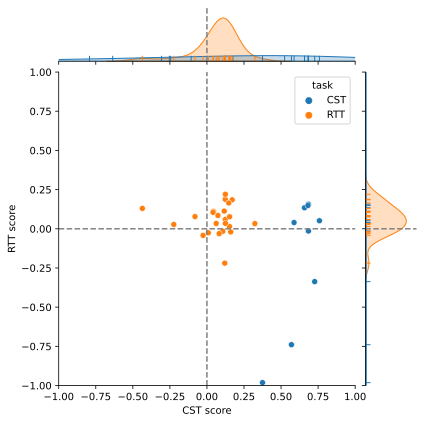

In [7]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_cst_unique',
    hand_or_cursor='Hand',
    pos_or_vel='velocity',
    trace_component=0,
)


/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



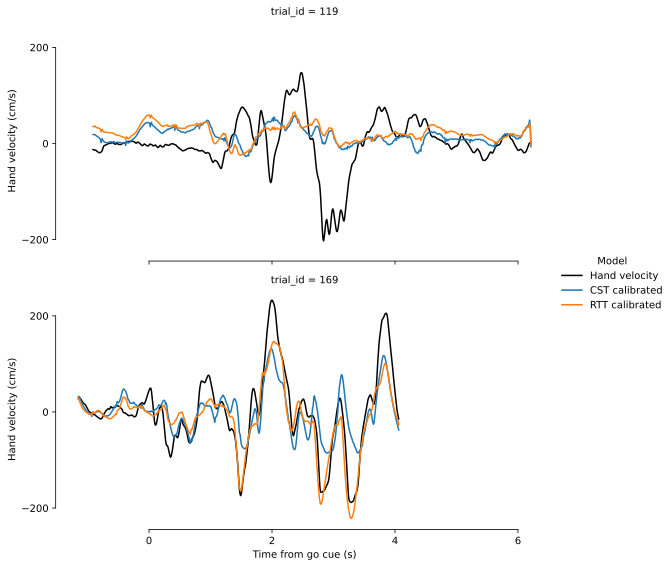

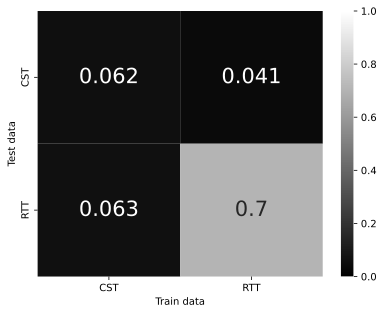

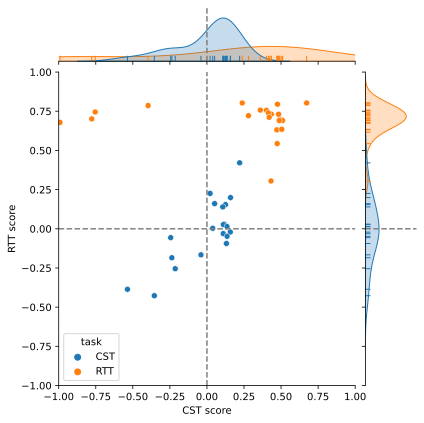

In [60]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_rtt_unique',
    hand_or_cursor='Hand',
    pos_or_vel='velocity',
    trace_component=0,
)


...What? Training a decoder on CST trials using the RTT workspace (which should basically be like training on noise) actually works on RTT trials somewhat, even though it doesn't work for CST trials.

It doesn't seem to be from information leak through the subspace splitting--I checked that by training and testing the decoder on trials unseen by the subspace splitter. It's possible that the RTT unique space is just highly velocity-related, and any random direction in that space is likely to be a good predictor of velocity, assuming the correct scaling. Maybe this is worth a test.

/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



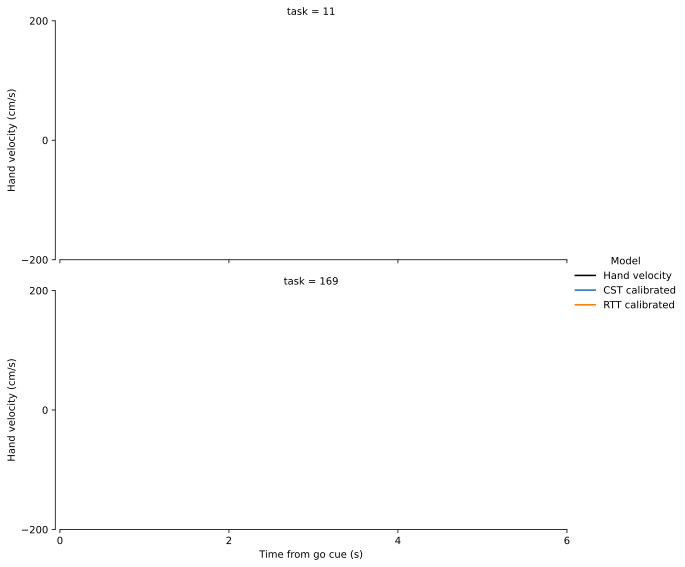

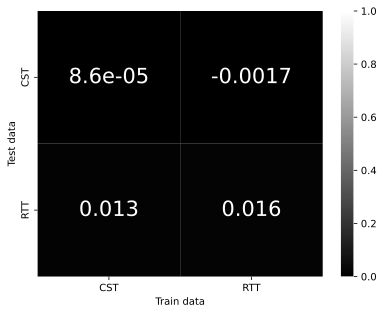

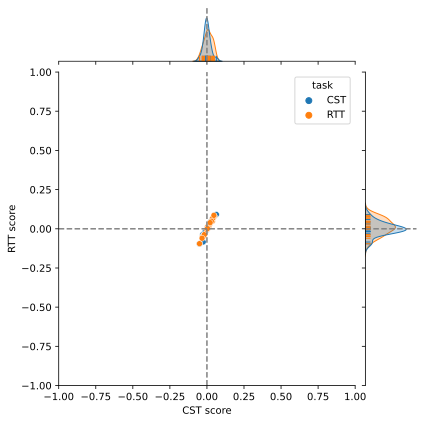

In [50]:
rtt_unique_dimensionality = td['lfads_rates_joint_pca_rtt_unique'].values[0].shape[1]
rand_vector = np.random.randn(rtt_unique_dimensionality)
rand_vector = rand_vector[:,None] / np.linalg.norm(rand_vector)
td_temp = (
    td
    .assign(
        rand_rtt_unique=lambda d: d['lfads_rates_joint_pca_rtt_unique'].apply(
            lambda x: np.dot(x, rand_vector)
        )
    )
)
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td_temp,
    'rand_rtt_unique',
    hand_or_cursor='Hand',
    pos_or_vel='velocity',
    trace_component=0,
)

Hmm... running the above code a few times, it seems that it's not generally true that a random direction in the RTT unique space is a good predictor of velocity, but it's true sometimes. And when it is, training a decoder on CST trials using the RTT unique space extracts the correct scale to use for the decoder (i.e. the scale is correct to mostly match the RTT-calibrated decoder--almost exaactly sometimes). This seems very strange to me, and I'm not sure what I'm looking at.

After some discussion with others, it seems possible that there are a few trials under each task that may provide some guidance for decoding in the other task, despite most trials having basically noise for variance in the unique space. More specifically, there may be some CST trials that have some activation in the RTT space that's predictive of hand velocity, which allows a decoder to pick up on that and generalize to RTT trials. One way to test this is to do a dropout analysis: which CST trials are most important for the generalization to RTT trials in the RTT unique space?

In [90]:
signal = 'lfads_rates_joint_pca_rtt_unique'
df = src.decoder_analysis.precondition_td(td, signal)
df_cst = df.groupby('task').get_group('CST')
df_rtt = df.groupby('task').get_group('RTT')
dropped_scores, dropped_trials = src.decoder_analysis.trial_dropout_analysis(
    df_train=df_cst,
    df_test=df_rtt,
    signal=signal,
    target_name='Hand velocity',
    drop_style='random',
)
px.line(dropped_scores,hover_name=dropped_trials)

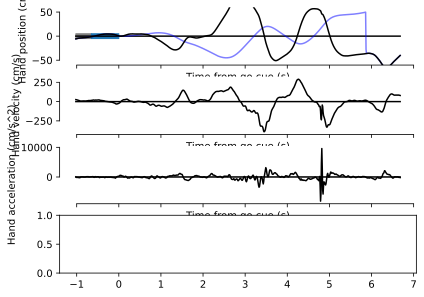

In [47]:
trial_to_plot = dropped_trials[2]
trial = td.loc[td['trial_id']==trial_to_plot,:].squeeze()
fig,axs = plt.subplots(4,1,sharex=True)
src.plot.plot_hand_trace(trial,ax=axs[0],timesig='Time from go cue (s)')
src.plot.plot_hand_velocity(trial,ax=axs[1],timesig='Time from go cue (s)')
src.plot.plot_hand_acc(trial,ax=axs[2],timesig='Time from go cue (s)')

In [68]:
import plotly.express as px
px.line(dropped_scores)

In [92]:
import plotly.express as px

signal = 'lfads_rates_joint_pca_rtt_unique'
df = src.decoder_analysis.precondition_td(td, signal)
models = src.decoder_analysis.fit_models(df, signal,target_name='Hand velocity')

trial_scores = src.decoder_analysis.score_trials(df.loc[df['Test set']],signal,models, target_name='Hand velocity')

fig = px.scatter(
    trial_scores.reset_index(),
    x='CST score',
    y='RTT score',
    color='task',
    hover_data=['trial_id'],
    marginal_x='violin',
    marginal_y='violin',
    template='plotly_white',
    width=600,
    height=600,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.show()

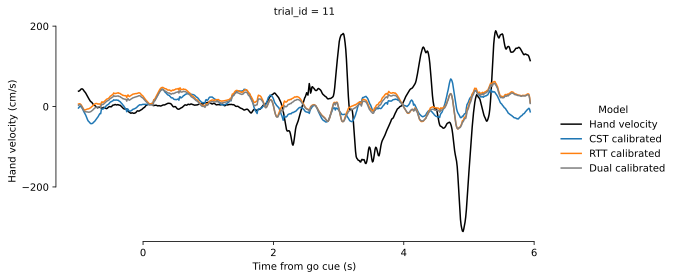

In [95]:
trials_to_plot = [11]
trial_pred = (
    df
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .reset_index()
    .melt(
        id_vars=['trial_id','Time from go cue (s)','task'],
        value_vars=['Hand velocity','CST calibrated','RTT calibrated','Dual calibrated'],
        var_name='Model',
        value_name='Hand velocity (cm/s)',
    )
)
g=sns.relplot(
    data=trial_pred,
    x='Time from go cue (s)',
    y='Hand velocity (cm/s)',
    hue='Model',
    hue_order=['Hand velocity','CST calibrated','RTT calibrated','Dual calibrated'],
    palette=['k','C0','C1','0.5'],
    kind='line',
    row='trial_id',
    row_order=trials_to_plot,
    height=4,
    aspect=2,
)
g.axes[0,0].set_yticks([-200,0,200])
g.axes[0,0].set_xticks([0,2,4,6])
sns.despine(fig=g.fig,trim=True)